# Build Landsat-8 TIR Macro-localization Deep Learning Model

This notebook trains models to classify Landsat 8 TIR Band 10 image chips into cement and landcover.

TBD more...

## Install Earlier Version of fastai

In [1]:
!pip install fastai==1.0.61

     |████████████████████████████████| 239 kB 24.6 MB/s eta 0:00:01
  Attempting uninstall: fastai
    Found existing installation: fastai 2.0.13
    Uninstalling fastai-2.0.13:
      Successfully uninstalled fastai-2.0.13


## Import Libraries

In [2]:
import os
import random
import glob

import boto3

import pandas as pd
import numpy as np

import sklearn.model_selection
import torch
from torch import nn

from fastai import *
from fastai.vision import *
from fastai.widgets import ClassConfusion

## Download .tar File From S3 Bucket and Extract Contents

This tar file contains normalized PNGs for cement and landcover, divided into train and validate sets.

In [3]:
AWS_SOURCE_PATH = 'L8-TIR-macro-localization-model-build3'
IMG_DIR = '/scratch/ALD_L8_TIR_chips_v4p1_train3_cement_binary'

# Output
AWS_MODEL_PATH = 'L8-TIR-model-results3'

In [4]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('sfi-shared-assets')

bucket.download_file(str(Path(AWS_SOURCE_PATH, IMG_DIR.split('/')[-1]+'.tar')), 
                     IMG_DIR+'.tar')

In [5]:
unix_code = 'tar -C /scratch/ -xf '+IMG_DIR+'.tar'
os.system(unix_code)

0

## Set Random Seeds
Set random seeds to ensure reproducibility.

In [6]:
def set_random_seed(seed=42):
    random.seed(seed)

    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    np.random.seed(seed)
    
set_random_seed()

## Read in, Augment and Partition Image Data
Read in image files and augment them using flipping, rotation, zoom, lighting, warping, and affine transformations. Partition using fixed random seed for reprodicibility.

In [7]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True, 
                      max_lighting=None, 
                      max_zoom=1.5, 
                      max_warp=0.2)

data = (ImageDataBunch.from_folder(IMG_DIR, train='train', valid='validate', 
                                   ds_tfms=tfms, bs=16, num_workers=0, seed=42)
        .normalize(imagenet_stats))

Display class-wise counts for training and validation sets.

In [8]:
def get_classwise_counts(items, classes):
    series = pd.value_counts(items).sort_index()
    series.index = classes
    
    return series

for subset, label in zip((data.train_ds, data.valid_ds), ('Training set', 'Validation set')):
    print('--- {} ---'.format(label))
    print(get_classwise_counts(subset.y.items, subset.classes))

--- Training set ---
cement        910
landcover    2116
dtype: int64
--- Validation set ---
cement       228
landcover    529
dtype: int64


For exploratory purposes, display a sample of images from a single training batch.

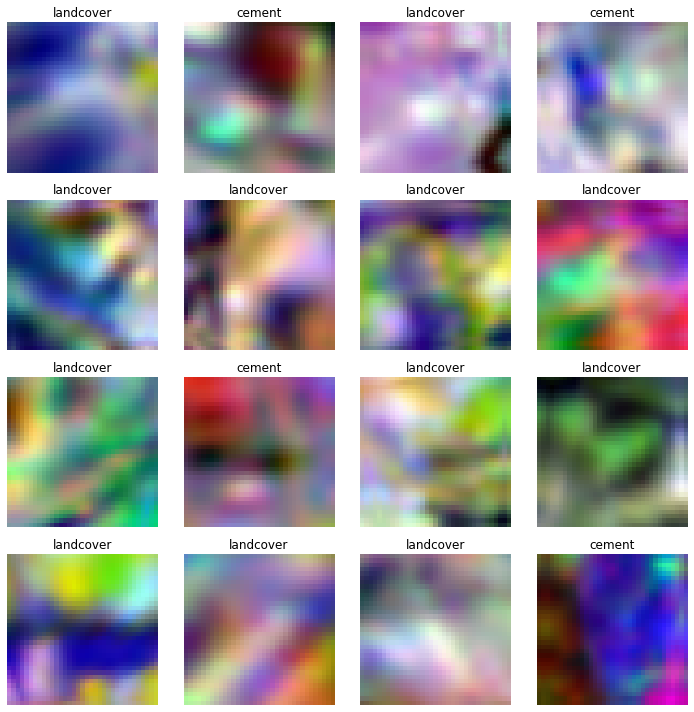

In [9]:
data.show_batch(rows=4, figsize=(10,10))

## Common Setup for Pre-trained Models

In [10]:
results = {}
interpretations = {}

In [11]:
weights = [1, 1]
# Replace the weight for the most abundant class with a smaller value
weights[np.argmax(get_classwise_counts(data.train_ds.y.items, data.train_ds.classes).values)] = 0.2
class_weights = torch.FloatTensor(weights).cuda()
loss_w = nn.CrossEntropyLoss(weight=class_weights)

In [12]:
weights

[1, 0.2]

In [13]:
# Instantiate metrics
recall = Recall()
precision = Precision()
# fbeta = MultiLabelFbeta(beta =1)
fbeta = FBeta()
metrics_all = [accuracy, recall, precision, fbeta]
metrics_labels = ['Accuracy', 'Recall', 'Precision', 'Fbeta']

## Functions to Tune Learning Rate

Tunes the learning rate based on Smith's (2015) range test.

In [14]:
def find_learning_rate(learner, show_plot=True):
    learner.lr_find()
    if show_plot:
        learner.recorder.plot()

In [15]:
def fit_recall_optimised(learner, n_epochs, max_learning_rate, model_filename):
    learner.fit_one_cycle(n_epochs, max_learning_rate,
                          callbacks=[callbacks.SaveModelCallback(learner, every='improvement', monitor='recall', name=model_filename)])

    learner.recorder.plot_losses() #, learner.recorder.plot_metrics()
    interpretation = ClassificationInterpretation.from_learner(learner)
    interpretation.plot_confusion_matrix(title='Confusion matrix', dpi=100)
    
    return interpretation

In [16]:
def get_statistics(learner):
    return dict(zip(metrics_labels, np.array(learner.validate(metrics=metrics_all))[1:]))

## Run 1 - Resnet50

Adapt Resnet50 using a weighted cross entropy as a custom loss function and using mixup to train the model. In addition, we will optimise models for recall, by selecting among training epochs.

### Define Learner (Resnet50)

In [17]:
learner = cnn_learner(data, 
                      models.resnet50,
                      # transfer learning on
                      pretrained=True,
                      # loss_func = LabelSmoothingCrossEntropy(), 
                      # class weighted cross entropy loss
                      loss_func=loss_w,
                      metrics=metrics_all,
                      opt_func=optim.Adam,
                      # batch norm at the end of the CNN
                      bn_final=True,
                      # nice callback for plotting loss for training and 
                      # validation during fitting 
                      # followed by mixup
                      callback_fns=ShowGraph).mixup()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


### Tune Learning Rate (Resnet50)

epoch,train_loss,valid_loss,accuracy,recall,precision,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


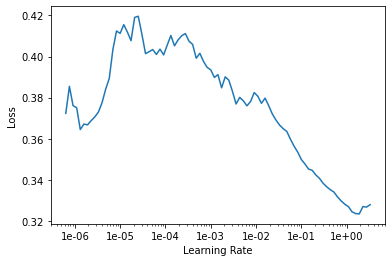

In [18]:
find_learning_rate(learner)

### Train Resnet50 with initial (high) learning rate

Based on the range test, a learning rate of 1E-02 appears to be reasonable, owing to the magnitude and slope of the associated loss.

epoch,train_loss,valid_loss,accuracy,recall,precision,f_beta,time
0,0.265947,0.274727,0.677675,0.669187,0.836879,0.697125,00:15
1,0.250936,0.233081,0.648613,0.604915,0.848806,0.641797,00:15
2,0.234177,0.202098,0.731836,0.680529,0.913706,0.717132,00:15
3,0.232496,0.190703,0.733157,0.691871,0.903704,0.725902,00:15
4,0.220058,0.184503,0.636724,0.529301,0.915033,0.578035,00:16
5,0.209934,0.182547,0.672391,0.576560,0.927052,0.623722,00:15
6,0.217114,0.178073,0.719947,0.646503,0.931880,0.688683,00:14
7,0.217441,0.185070,0.730515,0.686200,0.905237,0.721097,00:14
8,0.205879,0.175677,0.778071,0.739130,0.928741,0.770595,00:14
9,0.216316,0.176693,0.837516,0.867675,0.896484,0.873288,00:14


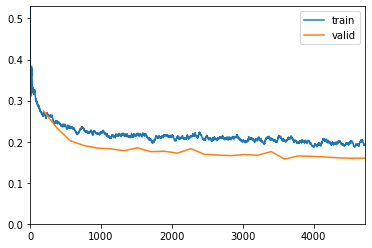

Better model found at epoch 0 with recall value: 0.6691871285438538.
Better model found at epoch 2 with recall value: 0.6805292963981628.
Better model found at epoch 3 with recall value: 0.6918714642524719.
Better model found at epoch 8 with recall value: 0.739130437374115.
Better model found at epoch 9 with recall value: 0.8676748871803284.


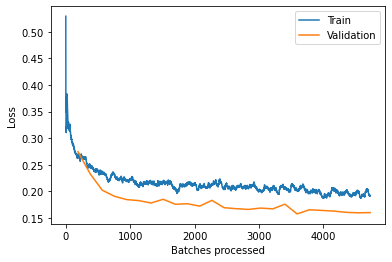

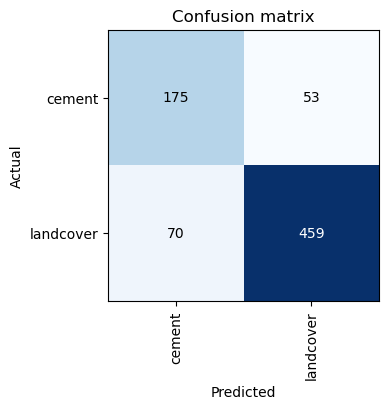

In [19]:
fit_recall_optimised(learner, n_epochs=25, max_learning_rate=1e-02, model_filename='resnet_temp')

### Determine new learning rate (Resnet50)

Fine tune the entire model. We perform this by unfreezing the model, then repeating the learning rate range test.

epoch,train_loss,valid_loss,accuracy,recall,precision,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


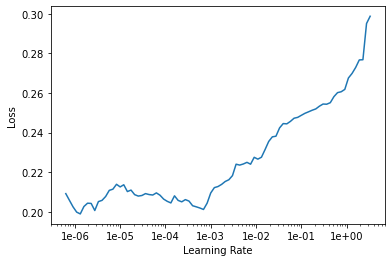

In [20]:
# load the model with the best recall
learner.load('resnet_temp')
learner.unfreeze()
find_learning_rate(learner)

### Retrain Resnet50 with low learning rate

Based on the range test, further train the model using a learning rate of 10E-4.

epoch,train_loss,valid_loss,accuracy,recall,precision,f_beta,time
0,0.204432,0.169508,0.788639,0.756144,0.928074,0.785238,00:17
1,0.203698,0.172434,0.780713,0.752363,0.919169,0.780698,00:17
2,0.202614,0.173840,0.770145,0.716446,0.940447,0.752283,00:17
3,0.210087,0.171924,0.656539,0.525520,0.968641,0.578444,00:17
4,0.201960,0.169419,0.764861,0.718336,0.929095,0.752475,00:18
5,0.208038,0.166913,0.738441,0.672968,0.934383,0.712855,00:17
6,0.205180,0.166775,0.742404,0.689981,0.921717,0.726513,00:16
7,0.200160,0.168993,0.750330,0.701323,0.922886,0.736696,00:17
8,0.202606,0.164804,0.734478,0.665406,0.936170,0.706260,00:16
9,0.198662,0.164803,0.741083,0.678639,0.932468,0.717713,00:16


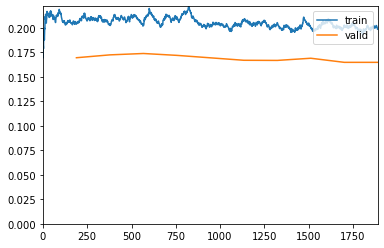

Better model found at epoch 0 with recall value: 0.7561436891555786.


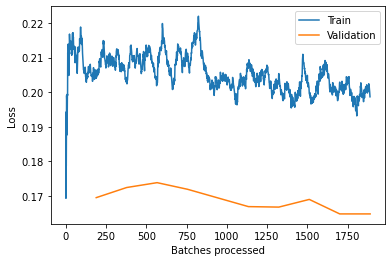

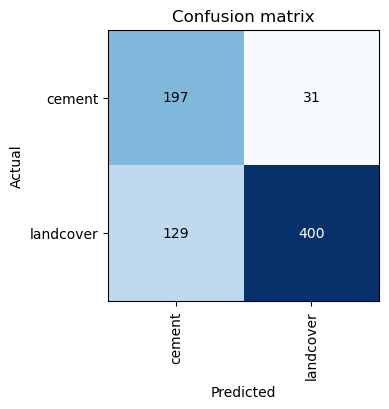

In [21]:
fit_recall_optimised(learner, n_epochs=10, max_learning_rate=1e-04, model_filename='resnet_temp')

### Retrain Resnet50 from best recall-optimized model

Load the best recall-optimised model, freeze and re-train.

epoch,train_loss,valid_loss,accuracy,recall,precision,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


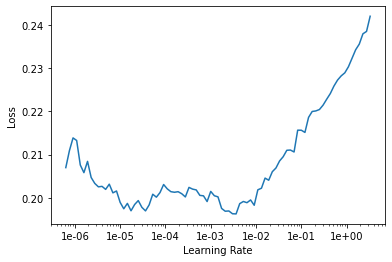

In [22]:
learner.load('resnet_temp')
learner.freeze()
find_learning_rate(learner)

epoch,train_loss,valid_loss,accuracy,recall,precision,f_beta,time
0,0.219653,0.168866,0.774108,0.735350,0.926190,0.766956,00:14
1,0.210384,0.170079,0.759577,0.695652,0.946015,0.734531,00:15
2,0.206512,0.171572,0.743725,0.672968,0.944297,0.713999,00:15
3,0.202504,0.165244,0.788639,0.759924,0.924138,0.787926,00:15
4,0.206028,0.161847,0.797886,0.771267,0.927273,0.798122,00:15
5,0.194960,0.159769,0.783355,0.742911,0.933492,0.774537,00:14
6,0.200898,0.158085,0.778071,0.731569,0.937046,0.765124,00:14
7,0.197027,0.158782,0.803170,0.776938,0.929864,0.803362,00:14
8,0.192668,0.156965,0.795244,0.765595,0.928899,0.793495,00:14
9,0.195651,0.159710,0.808454,0.790170,0.924779,0.813863,00:15


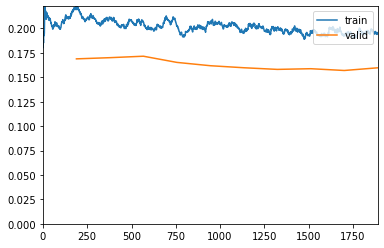

Better model found at epoch 0 with recall value: 0.735349714756012.
Better model found at epoch 3 with recall value: 0.7599244117736816.
Better model found at epoch 4 with recall value: 0.771266520023346.
Better model found at epoch 7 with recall value: 0.7769376039505005.
Better model found at epoch 9 with recall value: 0.7901701331138611.


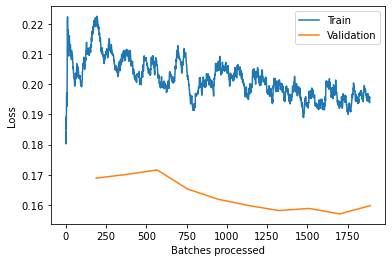

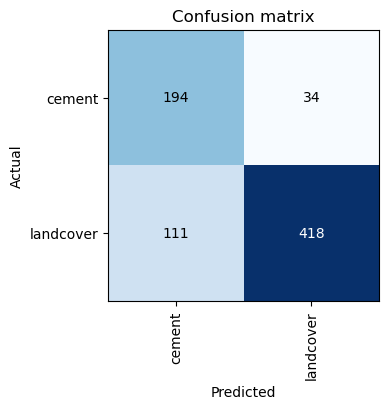

In [23]:
fit_recall_optimised(learner, n_epochs=10, max_learning_rate=7e-04, model_filename='resnet_temp')

### Final Resnet50 training

As a final step, load the best recall-optimised model, unfreeze and re-train using a low learning rate.

epoch,train_loss,valid_loss,accuracy,recall,precision,f_beta,time
0,0.195385,0.159185,0.803170,0.778828,0.927928,0.804687,00:17
1,0.188892,0.159866,0.803170,0.778828,0.927928,0.804687,00:17
2,0.195647,0.160005,0.809775,0.786389,0.930649,0.811549,00:17
3,0.203428,0.156879,0.820343,0.807183,0.926247,0.828483,00:16
4,0.199515,0.159493,0.820343,0.812854,0.920771,0.832366,00:16
5,0.196624,0.159028,0.803170,0.775047,0.931818,0.802034,00:17
6,0.193497,0.157053,0.785997,0.742911,0.937948,0.775148,00:17
7,0.197384,0.154251,0.793923,0.761815,0.930716,0.790506,00:17
8,0.197846,0.157642,0.804491,0.778828,0.930023,0.805002,00:17
9,0.197180,0.157153,0.812417,0.793951,0.927152,0.817439,00:17


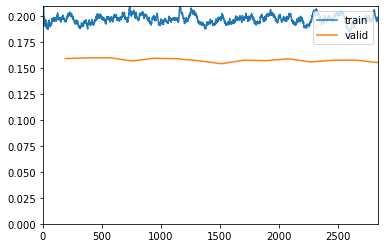

Better model found at epoch 0 with recall value: 0.778827965259552.
Better model found at epoch 2 with recall value: 0.7863894104957581.
Better model found at epoch 3 with recall value: 0.8071833848953247.
Better model found at epoch 4 with recall value: 0.8128544688224792.


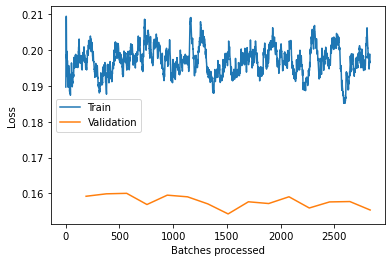

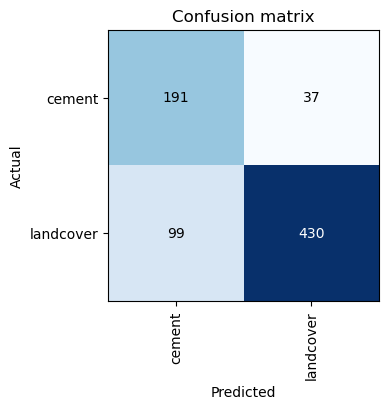

In [24]:
learner.load('resnet_temp')
learner.unfreeze()
interpretations['resnet'] = fit_recall_optimised(learner, n_epochs=15, max_learning_rate=1e-06, model_filename='resnet_temp')

In [25]:
learner.export(str(Path('resnet50_cement_binary_final.pkl')))
#results['resnet'] = get_statistics(learner)
#results['resnet']

In [26]:
pred, actual = learner.get_preds(ds_type=DatasetType.Train)
pred = np.array(pred)

## Run 2 - VGG13

Adapt VGG13 using a weighted cross entropy as a custom loss function and using mixup to train the model. In addition, we will optimise models for recall, by selecting among training epochs.

### Define Learner (VGG13)

In [27]:
learner = cnn_learner(data, 
                      models.vgg13_bn,
                      # transfer learning on
                      pretrained=True,
                      # loss_func = LabelSmoothingCrossEntropy(), 
                      # class weighted cross entropy loss
                      loss_func=loss_w,
                      metrics=metrics_all,
                      opt_func=optim.Adam,
                      # batch norm at the end of the CNN
                      bn_final=True,
                      # nice callback for plotting loss for training and 
                      # validation during fitting 
                      # followed by mixup
                      callback_fns=ShowGraph).mixup()

Downloading: "https://download.pytorch.org/models/vgg13_bn-abd245e5.pth" to /home/jovyan/.cache/torch/hub/checkpoints/vgg13_bn-abd245e5.pth


### Tune Learning Rate (VGG13)

Tune the learning rate based on Smith's (2015) range test.

epoch,train_loss,valid_loss,accuracy,recall,precision,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


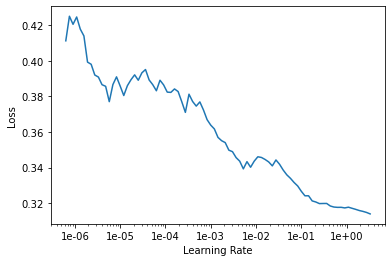

In [28]:
find_learning_rate(learner)

### First Round of VGG13 Training with High Learning Rate

Based on the range test, a learning rate of 1E-02 appears to be reasonable, owing to the magnitude and slope of the associated loss.

epoch,train_loss,valid_loss,accuracy,recall,precision,f_beta,time
0,0.287589,0.260119,0.663144,0.654064,0.827751,0.682715,00:08
1,0.259649,0.234053,0.589168,0.485822,0.868243,0.532753,00:08
2,0.232064,0.212448,0.591810,0.474480,0.890071,0.523353,00:08
3,0.221401,0.197212,0.589168,0.449905,0.922481,0.501264,00:08
4,0.222695,0.191387,0.688243,0.616257,0.908078,0.658586,00:08
5,0.213530,0.183496,0.660502,0.553875,0.933121,0.602881,00:08
6,0.214674,0.180185,0.722589,0.669187,0.910026,0.706587,00:08
7,0.217132,0.181131,0.689564,0.616257,0.910615,0.658852,00:08
8,0.210752,0.179924,0.661823,0.550095,0.941748,0.600000,00:08
9,0.213093,0.178567,0.760898,0.737240,0.902778,0.765306,00:08


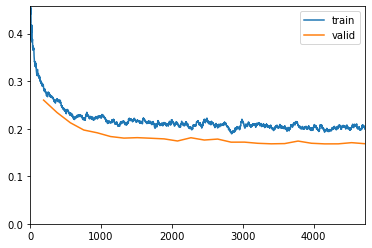

Better model found at epoch 0 with recall value: 0.6540642976760864.
Better model found at epoch 6 with recall value: 0.6691871285438538.
Better model found at epoch 9 with recall value: 0.7372400760650635.
Better model found at epoch 23 with recall value: 0.771266520023346.


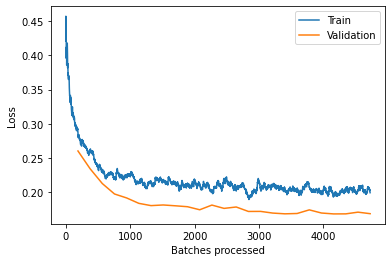

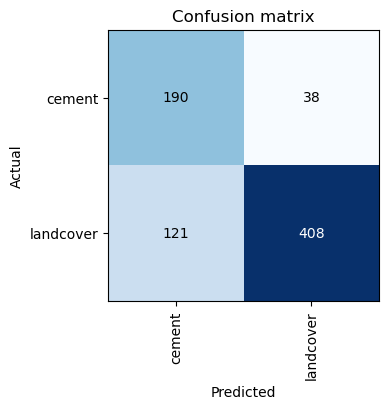

In [29]:
fit_recall_optimised(learner, n_epochs=25, max_learning_rate=1e-02, model_filename='vgg_temp')

### Repeat Learning Rate Test and Retrain (VGG13)

Fine tune the entire model. We perform this by unfreezing the model, then repeating the learning rate range test.

epoch,train_loss,valid_loss,accuracy,recall,precision,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


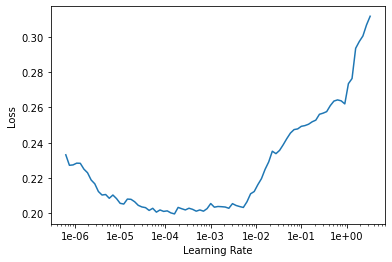

In [30]:
# load the model with the best recall
learner.load('vgg_temp')
learner.unfreeze()
find_learning_rate(learner)

Based on the range test, further train the model using a learning rate of 10E-4.

epoch,train_loss,valid_loss,accuracy,recall,precision,f_beta,time
0,0.200363,0.165081,0.738441,0.672968,0.934383,0.712855,00:09
1,0.198407,0.169036,0.759577,0.722117,0.916067,0.754046,00:09
2,0.204250,0.179825,0.618230,0.483932,0.941176,0.536013,00:09
3,0.203854,0.168900,0.795244,0.776938,0.917411,0.801482,00:09
4,0.206491,0.157132,0.782034,0.750473,0.923256,0.779654,00:09
5,0.201747,0.167089,0.834875,0.852552,0.905622,0.862663,00:09
6,0.196695,0.167696,0.792602,0.784499,0.906114,0.806138,00:09
7,0.199938,0.164777,0.793923,0.775047,0.917226,0.799844,00:09
8,0.193960,0.162929,0.791281,0.767486,0.920635,0.793899,00:09
9,0.201919,0.163230,0.779392,0.750473,0.918981,0.779042,00:09


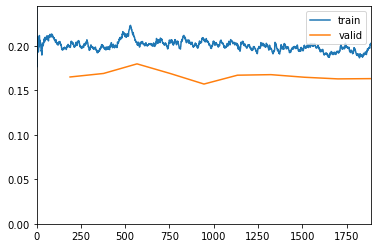

Better model found at epoch 0 with recall value: 0.6729678511619568.
Better model found at epoch 1 with recall value: 0.7221171855926514.
Better model found at epoch 3 with recall value: 0.7769376039505005.
Better model found at epoch 5 with recall value: 0.8525519967079163.


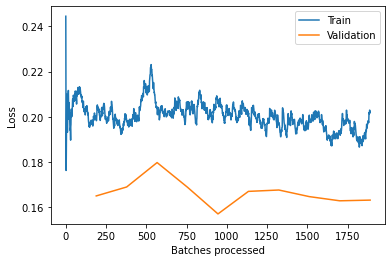

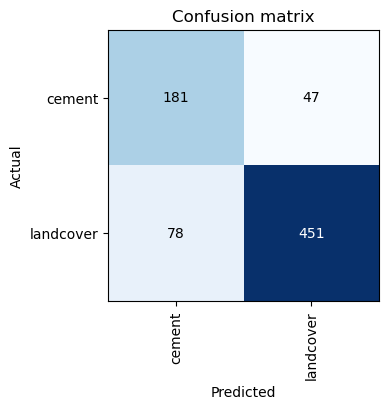

In [31]:
fit_recall_optimised(learner, n_epochs=10, max_learning_rate=1e-04, model_filename='vgg_temp')

### Retrain from recall-optimiated model (VGG13)

Load the best recall-optimised model, freeze and re-train.

epoch,train_loss,valid_loss,accuracy,recall,precision,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


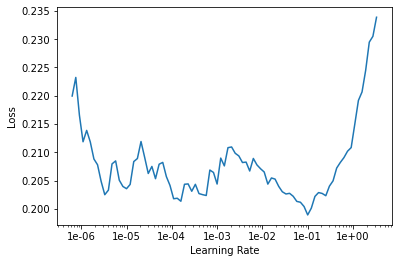

In [32]:
learner.load('vgg_temp')
learner.freeze()
find_learning_rate(learner)

epoch,train_loss,valid_loss,accuracy,recall,precision,f_beta,time
0,0.201787,0.160372,0.793923,0.767486,0.924829,0.794521,00:08
1,0.191244,0.159121,0.805812,0.792060,0.918860,0.814541,00:08
2,0.197916,0.155763,0.793923,0.758034,0.934732,0.787819,00:08
3,0.194452,0.159198,0.813738,0.807183,0.916309,0.826878,00:08
4,0.192905,0.157573,0.778071,0.742911,0.924706,0.773318,00:08
5,0.192534,0.156615,0.784676,0.754253,0.923611,0.782967,00:08
6,0.201438,0.158268,0.809775,0.797732,0.919390,0.819417,00:08
7,0.197703,0.158292,0.801849,0.782609,0.922049,0.807018,00:08
8,0.188624,0.161151,0.817701,0.812854,0.916844,0.831722,00:08
9,0.188889,0.157530,0.807133,0.790170,0.922737,0.813546,00:08


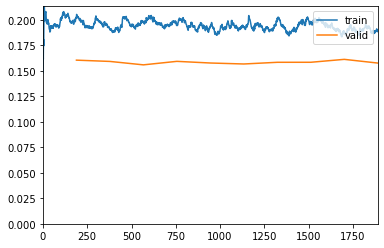

Better model found at epoch 0 with recall value: 0.7674857974052429.
Better model found at epoch 1 with recall value: 0.7920604944229126.
Better model found at epoch 3 with recall value: 0.8071833848953247.
Better model found at epoch 8 with recall value: 0.8128544688224792.


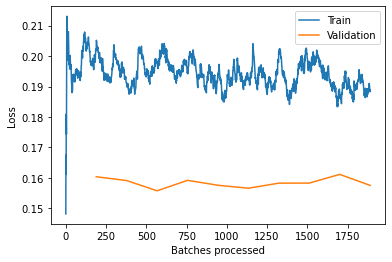

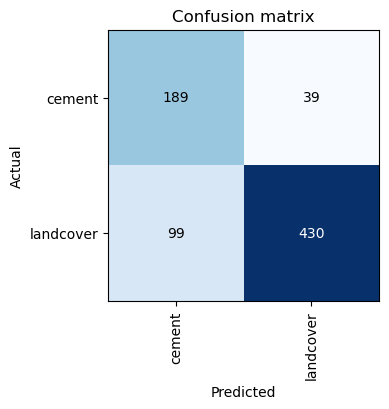

In [33]:
fit_recall_optimised(learner, n_epochs=10, max_learning_rate=7e-04, model_filename='vgg_temp')

### Final training of VGG13 with low learning rate

As a final step, load the best recall-optimised model, unfreeze and re-train using a low learning rate.

epoch,train_loss,valid_loss,accuracy,recall,precision,f_beta,time
0,0.185233,0.158390,0.815059,0.809074,0.916488,0.828494,00:09
1,0.190806,0.159285,0.799207,0.778828,0.921700,0.803746,00:09
2,0.197745,0.159185,0.808454,0.799622,0.915584,0.820403,00:09
3,0.199110,0.161815,0.826948,0.835539,0.909465,0.849347,00:09
4,0.196307,0.156796,0.797886,0.776938,0.921525,0.802108,00:09
5,0.206333,0.161719,0.836196,0.852552,0.907445,0.862993,00:09
6,0.189822,0.157941,0.812417,0.803403,0.917927,0.823963,00:09
7,0.188751,0.157859,0.793923,0.769376,0.922902,0.795855,00:09
8,0.204774,0.156364,0.796565,0.773157,0.923251,0.799140,00:09
9,0.191979,0.160477,0.825628,0.827977,0.914405,0.843931,00:09


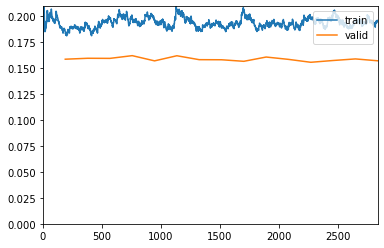

Better model found at epoch 0 with recall value: 0.8090737462043762.
Better model found at epoch 3 with recall value: 0.8355387449264526.
Better model found at epoch 5 with recall value: 0.8525519967079163.


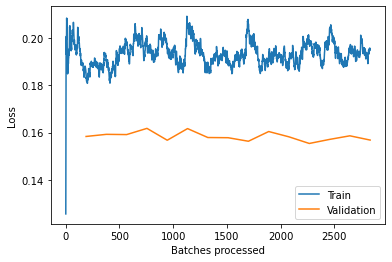

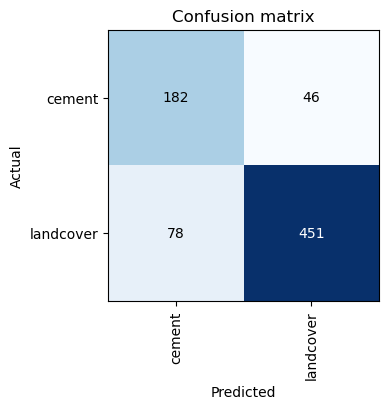

In [34]:
learner.load('vgg_temp')
learner.unfreeze()
interpretations['vgg'] = fit_recall_optimised(learner, n_epochs=15, max_learning_rate=1e-06, model_filename='vgg_temp')

In [35]:
learner.export(str(Path('vgg13_cement_binary_final.pkl')))
results['vgg'] = get_statistics(learner)
results['vgg']

{'Accuracy': 0.8361955,
 'Recall': 0.852552,
 'Precision': 0.90744466,
 'Fbeta': 0.8629927}

## Run 3 - Densenet161

### Define Learner (Densenet161)

Adapt Densenet161 using a weighted cross entropy as a custom loss function and using mixup to train the model. In addition, we will optimise models for recall, by selecting among training epochs.

In [36]:
learner = cnn_learner(data, 
                      models.densenet161,
                      # transfer learning on
                      pretrained=True,
                      # loss_func = LabelSmoothingCrossEntropy(), 
                      # class weighted cross entropy loss
                      loss_func=loss_w,
                      metrics=metrics_all,
                      opt_func=optim.Adam,
                      # batch norm at the end of the CNN
                      bn_final=True,
                      # nice callback for plotting loss for training and 
                      # validation during fitting 
                      # followed by mixup
                      callback_fns=ShowGraph).mixup()

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /home/jovyan/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


### Tune Learning Rate (Densenet161)

Tune the learning rate based on Smith's (2015) range test.

epoch,train_loss,valid_loss,accuracy,recall,precision,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


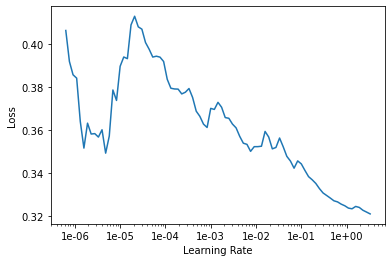

In [37]:
find_learning_rate(learner)

Based on the range test, a learning rate of 1E-02 appears to be reasonable, owing to the magnitude and slope of the associated loss.

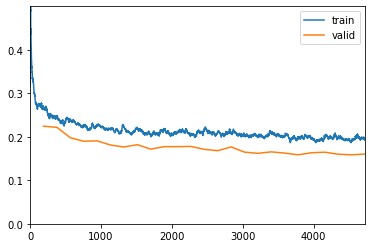

Better model found at epoch 0 with recall value: 0.6011342406272888.
Better model found at epoch 3 with recall value: 0.6427221298217773.
Better model found at epoch 5 with recall value: 0.6880907416343689.
Better model found at epoch 6 with recall value: 0.703213632106781.
Better model found at epoch 12 with recall value: 0.706994354724884.
Better model found at epoch 14 with recall value: 0.8015123009681702.


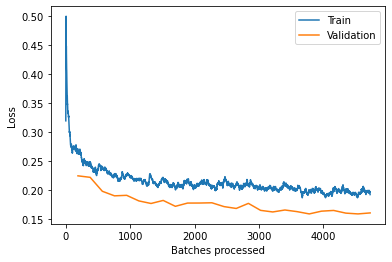

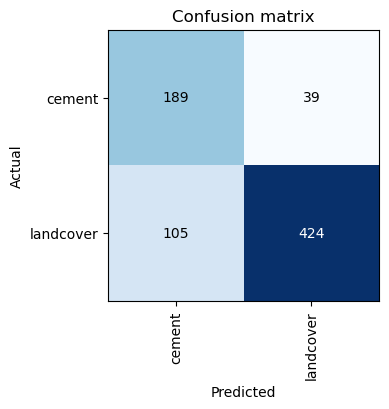

In [38]:
fit_recall_optimised(learner, n_epochs=25, max_learning_rate=1e-02, model_filename='densenet_temp')

### Retrain Densenet161 with lower learning rate

Fine tune the entire model. We perform this by unfreezing the model, then repeating the learning rate range test.

epoch,train_loss,valid_loss,accuracy,recall,precision,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


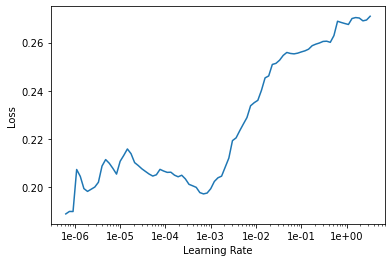

In [39]:
# load the model with the best recall
learner.load('densenet_temp')
learner.unfreeze()
find_learning_rate(learner)

Based on the range test, further train the model using a learning rate of 10E-4.

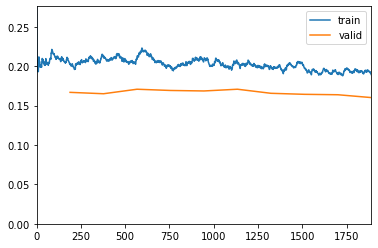

Better model found at epoch 0 with recall value: 0.7542533278465271.
Better model found at epoch 6 with recall value: 0.7769376039505005.


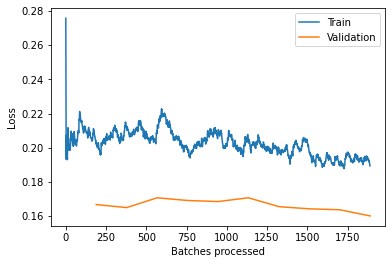

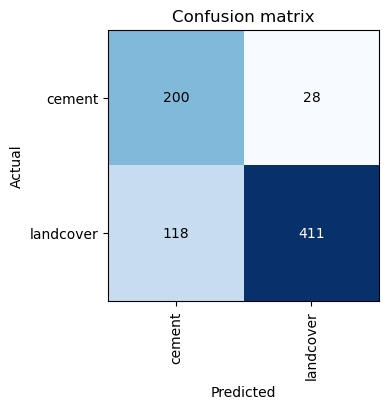

In [40]:
fit_recall_optimised(learner, n_epochs=10, max_learning_rate=1e-04, model_filename='densenet_temp')

### Retrain recall-optimized model (Densenet161)

Load the best recall-optimised model, freeze and re-train.

epoch,train_loss,valid_loss,accuracy,recall,precision,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


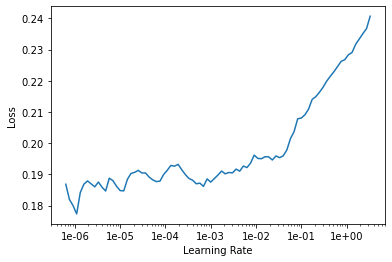

In [41]:
learner.load('densenet_temp')
learner.freeze()
find_learning_rate(learner)

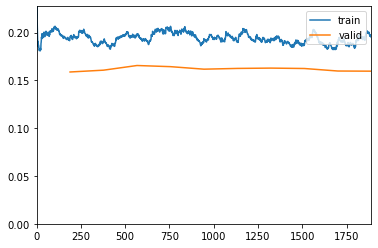

Better model found at epoch 0 with recall value: 0.7334593534469604.
Better model found at epoch 1 with recall value: 0.7504726052284241.
Better model found at epoch 8 with recall value: 0.7523629665374756.


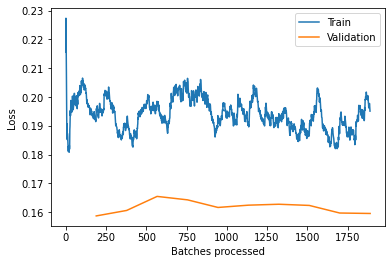

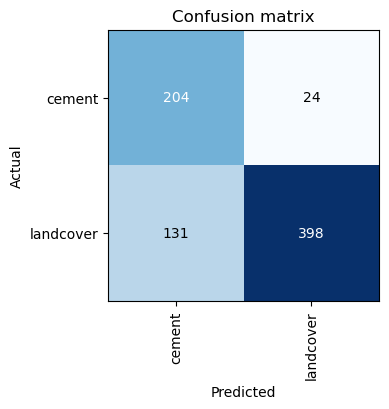

In [42]:
fit_recall_optimised(learner, n_epochs=10, max_learning_rate=7e-04, model_filename='densenet_temp')

### Final training of Densenet161 with low learning rate

As a final step, load the best recall-optimised model, unfreeze and re-train using a low learning rate.

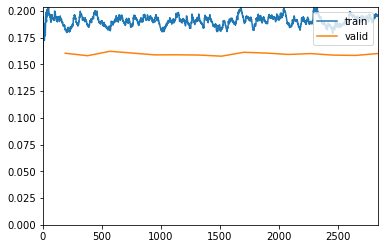

Better model found at epoch 0 with recall value: 0.7107750177383423.
Better model found at epoch 1 with recall value: 0.7221171855926514.
Better model found at epoch 4 with recall value: 0.735349714756012.
Better model found at epoch 5 with recall value: 0.7542533278465271.
Better model found at epoch 9 with recall value: 0.771266520023346.


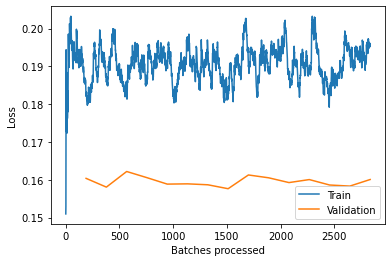

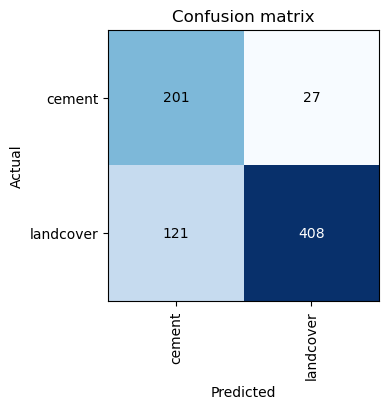

In [43]:
learner.load('densenet_temp')
learner.unfreeze()
interpretations['densenet'] = fit_recall_optimised(learner, n_epochs=15, max_learning_rate=1e-06, model_filename='densenet_temp')

In [44]:
learner.export(str(Path('densenet161_cement_binary_final.pkl')))
results['densenet'] = get_statistics(learner)
results['densenet']

{'Accuracy': 0.8044914,
 'Recall': 0.7712665,
 'Precision': 0.93793106,
 'Fbeta': 0.81442463}

## Obtain Summary of Results Across Models

In [45]:
pd.DataFrame(results)

,vgg,densenet
Accuracy,0.836196,0.804491
Recall,0.852552,0.771267
Precision,0.907445,0.937931
Fbeta,0.862993,0.814425


Based on obtained results, we select Resnet as the best-performing model

## Analyze Results Obtained Using VGG

In [46]:
ClassConfusion(interpretations['vgg'], classlist=['cement','landcover'], is_ordered=False, figsize=(8,8))

Please enter a value for `k`, or the top images you will see:  10


100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


<Figure size 432x288 with 0 Axes>

List of largest non-diagonal entries in the confusion matrix (actual | predicted | number of occurences).

In [47]:
interpretations['vgg'].most_confused()

[('landcover', 'cement', 78), ('cement', 'landcover', 46)]

## Upload models to S3

In [48]:
model_results = glob.glob(IMG_DIR+'/*.pkl')

In [49]:
for m in model_results:
    bucket.upload_file(m, AWS_SOURCE_PATH+'/'+AWS_MODEL_PATH+'/'+m.split('/')[-1])